# Load weights and CC200 ROI coordinates
- These weights are generated from the model **LR TP raw** without phenotypes. 
- **Negative weights**: These correspond to features that are informative for classifying subjects as *control*. The larger the absolute value of the weight, the more informative.
- **Positive weights**: Similar to the above, these correspond to features that are informative for classifying subjects as *ASD*

In [57]:
import pickle
import pandas as pd
import numpy as np
import re
import warnings

# occurrence in top k parameter
top_k = 50

# load weights
with open('LR_tangent_weights.pkl', "rb") as f:
    weights = pickle.load(f)
    weights = [weight*(-1) for weight in weights]

# load CC200 ROI labels  
CC200_df = pd.read_csv('CC200_ROI_labels.csv')

# load ROI coordinates 
temp = CC200_df.iloc[:, 2].map(lambda x: x.strip(')').strip('(').split(';')).tolist()
temp = [[float(j) for j in i] for i in temp]
atlas_coords = np.asarray(temp)

# Code to rank features in individual folds

In [58]:
# for a given fold (weight vector) count whether 
# a given feature appears in the top k weights
def get_ranks(weight, rank_dict):
    for ind, value in enumerate(np.absolute(weight).argsort(axis=None)):
        if value not in rank_dict:
            rank_dict[value] = [ind]
        else:
            rank_dict[value].append(ind)     

    return rank_dict

# sort all features rank over the 10 folds 
#(by number of occurrence)
def sort_ranks(fold_weights, ranks, top_k):
    no_feats = len(ranks)
    ranks_2 = dict()
    avg_weights = np.asarray([j.flatten() for j in fold_weights]).mean(axis=0)
    for i in ranks:
        ranks_2[i] = [1 if k in list(range(no_feats-top_k, no_feats)) else 0 for k in ranks[i]]
        ranks_2[i] = [sum(ranks_2[i]), avg_weights[i]]
    sorted_ranks = sorted(ranks_2.items(), key=lambda x: x[1][0], reverse=True)
    return sorted_ranks

def rank_features(fold_weights, top_k=50, abs_rank=True):
    
    ranks = dict()
    ranks_pos = dict()
    ranks_neg = dict()
            
    for weight in weights:
        weight = weight.flatten()
        if abs_rank != True:
            weight_pos = weight.copy()
            weight_neg = weight.copy()
            weight_pos[weight_pos <=0] = 0
            weight_neg[weight_neg >=0] = 0
            ranks_pos = get_ranks(weight_pos, ranks_pos)
            ranks_neg = get_ranks(weight_neg, ranks_neg)
        else:
            ranks = get_ranks(weight, ranks)
    
    if abs_rank != True:
        pos_ranks = sort_ranks(fold_weights, ranks_pos, top_k)
        neg_ranks = sort_ranks(fold_weights, ranks_neg, top_k)
        return (pos_ranks, neg_ranks)
    else:
        abs_ranks = sort_ranks(fold_weights, ranks, top_k)
        return abs_ranks

    
# identify each feature by pair of ROIs number, HO atlas names
# and centre of mass (COM)
def get_identification(df, CC200_df, size_conn_mat=200):
    new = np.zeros((200,200))
    inds = np.triu_indices_from(new, 1)
    
    tup_index1 = []
    tup_index2 = []
    tup_COM1 = []
    tup_COM2 = []
    tup_name1 = []
    tup_name2 = []
    
    pattern1 = re.compile('\["[\(\)a-zA-Z\s;]+": [\d\.]*\]')
    pattern2 = re.compile('[\d:\.\[\]]+')
    
    for i in range(df.shape[0]):
        feat_no = df.iloc[i, 0]
        tup_index1.append(inds[0][feat_no])
        tup_index2.append(inds[1][feat_no])
        ind1 = inds[0][feat_no]
        ind2 = inds[1][feat_no]
        tup_COM1.append(CC200_df.iloc[ind1, 2])
        tup_COM2.append(CC200_df.iloc[ind2, 2])
        tup_name1.append(pattern2.sub('', pattern1.match(CC200_df.iloc[ind1, 7]).group(0)))
        tup_name2.append(pattern2.sub('', pattern1.match(CC200_df.iloc[ind2, 7]).group(0)))

    df['ROI 1 index'] = tup_index1
    df['ROI 2 index'] = tup_index2
    df['ROI 1 COM'] = tup_COM1
    df['ROI 2 COM'] = tup_COM2
    df['ROI 1 HO name'] = tup_name1
    df['ROI 2 HO name'] = tup_name2
    
    return df 

# Rank features by absolute value

In [59]:
ranked_feats = rank_features(weights, top_k, abs_rank=True)

ranked_feats = [list(t) for t in zip(*ranked_feats)]
feat_no = ranked_feats[0]
ranks = ranked_feats[1]


rank_df = pd.DataFrame(ranks, columns = ['no occurrence in top '+str(top_k), 'average weight'])

rank_df.insert(0, 'feat_no', feat_no)
rank_df['abs_avg_weights'] = np.absolute(rank_df['average weight'])
rank_df = rank_df.sort_values(by=['no occurrence in top '+str(top_k), 'abs_avg_weights'], 
                              ascending=[False, False]).reset_index().drop(['index', 'abs_avg_weights'], axis=1)

# get feature ROI labels
rank_df = get_identification(rank_df, CC200_df)

### Ranked features by occurence in top k (absolute value)

- **feat_no**: number of feature in weight vector
- **no occurence in top 50**: number of times feature was present in the top 50 weights across 10 folds
- **average weight**: average feature weight over 10 folds
- **ROI index**: ROI numbers of the connected ROIs
- **ROI COM**: ROI centre of mass. Useful to identify ROI if HO name is none.
- **ROI HO name**: Harvard oxford brain atlas label of ROI. This value is none if not available

Where two features have the same rank, they are sorted by average weight so that the feature with a larger average weight is ranked higher.

In [60]:
rank_df.to_csv('top_50_features.csv')
rank_df.head(50)

,feat_no,no occurrence in top 50,average weight,ROI 1 index,ROI 2 index,ROI 1 COM,ROI 2 COM,ROI 1 HO name,ROI 2 HO name
0,9836,10,-0.371209,57,147,(1.5;-52.8;14.8),(1.7;-4.4;5.3),"""Right Precuneous Cortex""","""Right Thalamus"""
1,18413,10,-0.331556,144,198,(-31.9;-21.1;-18.8),(-15.0;-30.8;-18.3),"""Left Hippocampus""","""Left Parahippocampal Gyrus; posterior division"""
2,5487,10,0.318169,29,152,(2.9;-28.0;-36.0),(58.4;-7.8;-7.8),"""None""","""Right Superior Temporal Gyrus; anterior divis..."
3,11984,10,0.314143,73,159,(-44.0;33.0;-8.1),(0.1;20.4;-8.0),"""Left Frontal Orbital Cortex""","""Right Subcallosal Cortex"""
4,787,10,-0.303368,3,197,(-36.6;-13.9;-2.3),(30.8;-1.4;-36.2),"""Left Putamen""","""Right Temporal Fusiform Cortex; anterior divi..."
5,14045,10,-0.297277,91,123,(-18.7;-7.4;-15.9),(28.3;43.8;-13.5),"""Left Amygdala""","""Right Frontal Pole"""
6,10460,10,-0.295109,62,76,(-43.9;-52.7;-18.6),(17.2;-80.1;-28.7),"""Left Inferior Temporal Gyrus; temporooccipita...","""None"""
7,1965,9,-0.297593,10,31,(-58.9;-30.2;-2.4),(43.5;9.9;-36.2),"""Left Middle Temporal Gyrus; posterior division""","""Right Temporal Pole"""
8,9143,9,-0.278749,52,174,(44.6;29.2;-9.5),(30.8;-87.5;-10.9),"""Right Frontal Orbital Cortex""","""Right Occipital Fusiform Gyrus"""
9,7051,9,-0.276226,39,71,(1.6;33.3;24.3),(-56.4;-15.1;-15.3),"""Right Cingulate Gyrus; anterior division""","""Left Middle Temporal Gyrus; posterior division"""


# Rank features by absolute value independently for positive and negative weights

In [61]:
# ranked_feats returns two dataframes, one for the positve weight ranks
# and another for the negative weight ranks
ranked_feats = rank_features(weights, top_k, abs_rank=False)

pos_ranked_feats = ranked_feats[0]
neg_ranked_feats = ranked_feats[1]
pos_ranked_feats = [list(t) for t in zip(*pos_ranked_feats)]
neg_ranked_feats = [list(t) for t in zip(*neg_ranked_feats)]

pos_feat_no = pos_ranked_feats[0]
neg_feat_no = neg_ranked_feats[0]
pos_ranks = pos_ranked_feats[1]
neg_ranks = neg_ranked_feats[1]

pos_rank_df = pd.DataFrame(pos_ranks, columns = ['no occurrence in top '+str(top_k), 'average weight'])
neg_rank_df = pd.DataFrame(neg_ranks, columns = ['no occurrence in top '+str(top_k), 'average weight'])

pos_rank_df.insert(0, 'feat_no', pos_feat_no)
neg_rank_df.insert(0, 'feat_no', neg_feat_no)

pos_rank_df.loc[pos_rank_df['average weight'] <=0, 'average weight'] = 0
neg_rank_df.loc[neg_rank_df['average weight'] >=0, 'average weight'] = 0

pos_rank_df['abs_avg_weights'] = np.absolute(pos_rank_df['average weight'])
neg_rank_df['abs_avg_weights'] = np.absolute(neg_rank_df['average weight'])


pos_rank_df = pos_rank_df.sort_values(by=['no occurrence in top '+str(top_k), 'abs_avg_weights'], 
                                      ascending=[False, False]).reset_index().drop(['index', 'abs_avg_weights'], axis=1)
neg_rank_df = neg_rank_df.sort_values(by=['no occurrence in top '+str(top_k), 'abs_avg_weights'],
                                      ascending=[False, False]).reset_index().drop(['index', 'abs_avg_weights'], axis=1)

# get feature ROI labels for both positive and negative weight rankings
pos_rank_df = get_identification(pos_rank_df, CC200_df)
neg_rank_df = get_identification(neg_rank_df, CC200_df)

### Ranked features by occurence in top k for positive weights

In [62]:
pos_rank_df.to_csv('top_50_ASD_fts.csv')
pos_rank_df.head(50)

,feat_no,no occurrence in top 50,average weight,ROI 1 index,ROI 2 index,ROI 1 COM,ROI 2 COM,ROI 1 HO name,ROI 2 HO name
0,5487,10,0.318169,29,152,(2.9;-28.0;-36.0),(58.4;-7.8;-7.8),"""None""","""Right Superior Temporal Gyrus; anterior divis..."
1,11984,10,0.314143,73,159,(-44.0;33.0;-8.1),(0.1;20.4;-8.0),"""Left Frontal Orbital Cortex""","""Right Subcallosal Cortex"""
2,15003,10,0.267870,100,154,(-51.0;-3.6;-28.8),(21.3;-11.9;-16.4),"""Left Middle Temporal Gyrus; anterior division""","""Right Hippocampus"""
3,18247,10,0.266455,142,143,(53.5;-61.8;1.0),(52.1;28.0;4.9),"""Right Lateral Occipital Cortex; inferior divi...","""Right Inferior Frontal Gyrus; pars triangular..."
4,8640,10,0.259929,49,115,(-28.2;-6.3;58.0),(-55.9;-28.7;36.6),"""Left Precentral Gyrus""","""Left Supramarginal Gyrus; anterior division"""
5,16499,9,0.284813,117,120,(21.1;-59.3;-25.2),(-39.7;-12.9;13.3),"""None""","""Left Central Opercular Cortex"""
6,6881,9,0.283638,38,61,(62.9;-43.0;-7.8),(34.0;-31.4;-16.4),"""Right Middle Temporal Gyrus; temporooccipital...","""Right Temporal Fusiform Cortex; posterior div..."
7,8436,9,0.278527,48,61,(61.9;-21.1;-15.6),(34.0;-31.4;-16.4),"""Right Middle Temporal Gyrus; posterior divisi...","""Right Temporal Fusiform Cortex; posterior div..."
8,17354,9,0.269799,128,139,(-45.0;-0.7;-14.6),(55.1;-3.6;-25.4),"""Left Temporal Pole""","""Right Middle Temporal Gyrus; anterior division"""
9,9559,9,0.266114,55,155,(-51.9;-50.2;42.1),(-33.9;-53.8;49.5),"""Left Angular Gyrus""","""Left Superior Parietal Lobule"""


### Ranked features by occurence in top k for negative weights

In [63]:
neg_rank_df.to_csv('top_50_control_fts.csv')
neg_rank_df.head(50)

,feat_no,no occurrence in top 50,average weight,ROI 1 index,ROI 2 index,ROI 1 COM,ROI 2 COM,ROI 1 HO name,ROI 2 HO name
0,9836,10,-0.371209,57,147,(1.5;-52.8;14.8),(1.7;-4.4;5.3),"""Right Precuneous Cortex""","""Right Thalamus"""
1,18413,10,-0.331556,144,198,(-31.9;-21.1;-18.8),(-15.0;-30.8;-18.3),"""Left Hippocampus""","""Left Parahippocampal Gyrus; posterior division"""
2,787,10,-0.303368,3,197,(-36.6;-13.9;-2.3),(30.8;-1.4;-36.2),"""Left Putamen""","""Right Temporal Fusiform Cortex; anterior divi..."
3,1965,10,-0.297593,10,31,(-58.9;-30.2;-2.4),(43.5;9.9;-36.2),"""Left Middle Temporal Gyrus; posterior division""","""Right Temporal Pole"""
4,14045,10,-0.297277,91,123,(-18.7;-7.4;-15.9),(28.3;43.8;-13.5),"""Left Amygdala""","""Right Frontal Pole"""
5,10460,10,-0.295109,62,76,(-43.9;-52.7;-18.6),(17.2;-80.1;-28.7),"""Left Inferior Temporal Gyrus; temporooccipita...","""None"""
6,8165,10,-0.283325,46,93,(-13.8;12.6;-2.9),(14.2;-0.5;17.5),"""Left Putamen""","""Right Caudate"""
7,9143,10,-0.278749,52,174,(44.6;29.2;-9.5),(30.8;-87.5;-10.9),"""Right Frontal Orbital Cortex""","""Right Occipital Fusiform Gyrus"""
8,7051,10,-0.276226,39,71,(1.6;33.3;24.3),(-56.4;-15.1;-15.3),"""Right Cingulate Gyrus; anterior division""","""Left Middle Temporal Gyrus; posterior division"""
9,3628,10,-0.275515,19,38,(-32.7;19.7;2.0),(62.9;-43.0;-7.8),"""Left Insular Cortex""","""Right Middle Temporal Gyrus; temporooccipital..."


# Visualisation for ranking features by absolute value (top 10 weights)

In [64]:
# top 10 ranked features
for_plot_df = rank_df[['ROI 1 index', 'ROI 2 index', 'average weight', 'ROI 1 HO name', 'ROI 2 HO name']].head(10)

inds_1 = list(for_plot_df['ROI 1 index'])
inds_2 = list(for_plot_df['ROI 2 index'])
inds = list(zip(inds_1, inds_2))
top_weights = list(for_plot_df['average weight'])
ind_to_name = dict()

# top 10 ranked features HO atlas labels
for i, index in enumerate(inds):
    ind_to_name[index[0]] = for_plot_df.iloc[i, 3]
    ind_to_name[index[1]] = for_plot_df.iloc[i, 4]
    
indices = sorted(list(set(inds_1 + inds_2)))
index_map = dict()
inverse_map = dict()

for i, val in enumerate(indices):
    index_map[val] = i
    inverse_map[i] = val

new_size = len(index_map)
adj_mat = np.zeros(shape=(new_size, new_size))

for i in range(10):
    adj_mat[index_map[inds_1[i]], index_map[inds_2[i]]] = top_weights[i]
    adj_mat[index_map[inds_2[i]], index_map[inds_1[i]]] = top_weights[i]

new_atlas_cords = atlas_coords[indices]

## Correlation matrix

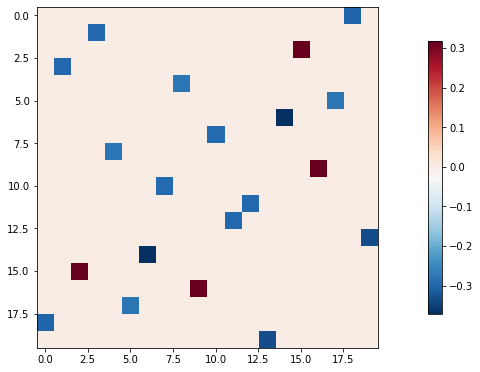

In [65]:
from nilearn import plotting
from matplotlib import pyplot as plt
%matplotlib inline

display = plotting.plot_matrix(adj_mat ,colorbar=True)

## Edge weights visualisation

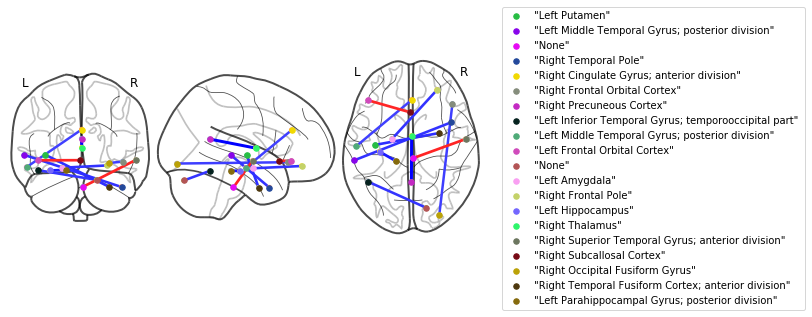

In [66]:
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
np.random.seed(12)

display = plotting.plot_connectome(adj_mat, new_atlas_cords, node_size=20, annotate=True)

labels = []

for j in range(new_size):
    labels.append(ind_to_name[inverse_map[j]])
    
for i in range(len(new_atlas_cords)):
    display.add_markers(marker_coords=[new_atlas_cords[i]], marker_color=list(np.random.rand(3,)), marker_size=30,
                        label=labels[i])

plt.legend(bbox_to_anchor=(1.1, 1.3))

plt.savefig('biomarkers.png', dpi=300, bbox_extra_artists=(plt.legend(bbox_to_anchor=(1.1, 1.3)),), bbox_inches='tight')


# Visualisation for independently ranked Positive/ negative features (top 10 weights)

In [67]:
for_plot_df_pos = pos_rank_df[['ROI 1 index', 'ROI 2 index', 'average weight', 'ROI 1 HO name', 'ROI 2 HO name']].head(5)
for_plot_df_neg = neg_rank_df[['ROI 1 index', 'ROI 2 index', 'average weight', 'ROI 1 HO name', 'ROI 2 HO name']].head(5)

inds_1 = list(for_plot_df_pos['ROI 1 index'])
inds_2 = list(for_plot_df_pos['ROI 2 index'])
inds_3 = list(for_plot_df_neg['ROI 1 index'])
inds_4 = list(for_plot_df_neg['ROI 2 index'])
inds_pos = list(zip(inds_1, inds_2))
inds_neg = list(zip(inds_3, inds_4))
ind_to_name = dict()

top_weights_pos = list(for_plot_df_pos['average weight'])
top_weights_neg = list(for_plot_df_neg['average weight'])

# top 5 positive features HO atlas labels
for i, index in enumerate(inds_pos):
    ind_to_name[index[0]] = for_plot_df_pos.iloc[i, 3]
    ind_to_name[index[1]] = for_plot_df_pos.iloc[i, 4]

# top 5 negative features HO atlas labels
for i, index in enumerate(inds_neg):
    ind_to_name[index[0]] = for_plot_df_neg.iloc[i, 3]
    ind_to_name[index[1]] = for_plot_df_neg.iloc[i, 4]

indices = sorted(list(set(inds_1 + inds_2 + inds_3 + inds_4)))
index_map = dict()
inverse_map = dict()

for i, val in enumerate(indices):
    index_map[val] = i
    inverse_map[i] = val
    
new_size = len(index_map)
adj_mat = np.zeros(shape=(new_size, new_size))

for i in range(5):
    adj_mat[index_map[inds_1[i]], index_map[inds_2[i]]] = top_weights_pos[i]
    adj_mat[index_map[inds_2[i]], index_map[inds_1[i]]] = top_weights_pos[i]
    adj_mat[index_map[inds_3[i]], index_map[inds_4[i]]] = top_weights_neg[i]
    adj_mat[index_map[inds_4[i]], index_map[inds_3[i]]] = top_weights_neg[i]

new_atlas_cords = atlas_coords[indices]

labels = []

for j in range(new_size):
    labels.append(ind_to_name[inverse_map[j]])

## Correlation matrix

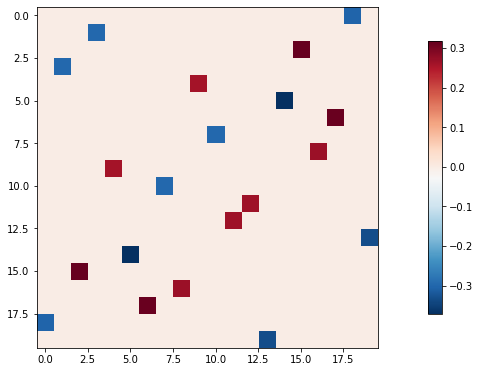

In [68]:
from nilearn import plotting
from matplotlib import pyplot as plt
%matplotlib inline

display = plotting.plot_matrix(adj_mat ,colorbar=True)

## Edge weights visualisation

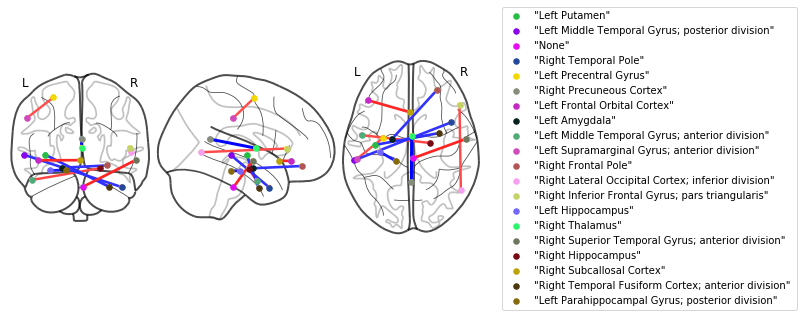

In [69]:
np.random.seed(12)

display = plotting.plot_connectome(adj_mat, new_atlas_cords, node_size=20, annotate=True)

labels = []

for j in range(new_size):
    labels.append(ind_to_name[inverse_map[j]])
    
for i in range(len(new_atlas_cords)):
    display.add_markers(marker_coords=[new_atlas_cords[i]], marker_color=list(np.random.rand(3,)), marker_size=30,
                        label=labels[i])

plt.legend(bbox_to_anchor=(1.1, 1.3))

plt.savefig('biomarkers.png', dpi=300, bbox_extra_artists=(plt.legend(bbox_to_anchor=(1.1, 1.3)),), bbox_inches='tight')
